In [8]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from icnn import ICNN  # Assuming ICNN is defined in your project

In [9]:

def train_loop(dataloader, model, loss_fn, optimizer):
    """ Fetches batches from dataloader and runs backpropagation on them """
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Key Code guaranteeing nonnegative Weight Matrix
        with torch.no_grad():
            for name, param in model.named_parameters():
                if "prim" in name: 
                    param.copy_(param.clamp(min=0))
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        


In [10]:
def test_loop(dataloader, model, loss_fn):
    """ Fetches batches from test data dataloader and fowards them through net

    Args:
        dataloader: torch.utils.data.Dataloader() instance
        model: Neural network model
        loss_fn: particular loss function to use

    Prints:
        Test Error and Average Loss
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

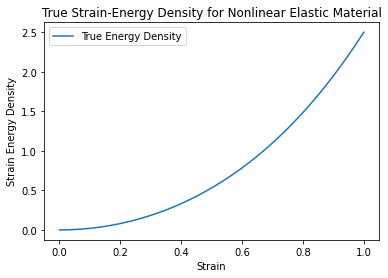

In [11]:
def call_train_loop(epochs, train_loader, test_loader, model, loss_fn, optimizer):
    """ Trains for a specified number of epochs """
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
        test_loop(test_loader, model, loss_fn)
    print("Done!")
    return model

# Define constants for synthetic nonlinear elasticity material
alpha = 2.0  # quadratic term
beta = 0.5   # quartic term

# Generate synthetic strain and strain energy density data
strain = torch.linspace(0, 1, 100).reshape(-1, 1)  # Strain values from 0 to 1
energy_density = alpha * strain**2 + beta * strain**4  # Strain energy density

# Plot true strain-energy density relationship for reference
plt.plot(strain.numpy(), energy_density.numpy(), label='True Energy Density')
plt.xlabel('Strain')
plt.ylabel('Strain Energy Density')
plt.title('True Strain-Energy Density for Nonlinear Elastic Material')
plt.legend()
plt.show()

In [12]:
# Modified train_icnn function to use synthetic data for nonlinear elasticity
def train_icnn_nonlinear_elasticity(learning_rate, epochs):
    """Trains ICNN on synthetic nonlinear elasticity data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Using {} device'.format(device))

    # Use synthetic strain data as a DataLoader-compatible dataset
    train_loader = TensorDataset(strain, energy_density)
    test_loader = DataLoader(train_loader, batch_size=10, shuffle=True)
    
    # Instantiate the ICNN model
    model = ICNN()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Use existing training loop structure
    trained_model = call_train_loop(epochs, train_loader, test_loader, model, loss_fn, optimizer)

    return trained_model

In [13]:
# Train the model and visualize results
if __name__ == "__main__":
    # Train the ICNN model using the modified function
    trained_model = train_icnn_nonlinear_elasticity(1e-3, 1000)

    # Generate predictions using the trained model
    with torch.no_grad():
        predicted_energy_density = trained_model(strain).cpu()

    # Plot true vs. predicted strain-energy density
    plt.plot(strain.numpy(), energy_density.numpy(), label='True Energy Density')
    plt.plot(strain.numpy(), predicted_energy_density.numpy(), label='Predicted by ICNN', linestyle='--')
    plt.xlabel('Strain')
    plt.ylabel('Strain Energy Density')
    plt.title('ICNN Prediction for Nonlinear Elastic Material')
    plt.legend()
    plt.show()

Using cpu device
Epoch 1
-------------------------------


AttributeError: 'TensorDataset' object has no attribute 'dataset'